In [10]:
import os

import torch
import torch.optim as optim
from torch.nn import CrossEntropyLoss
from torch.nn import functional as F
from torch.optim import Adam, AdamW

os.environ["WANDB_API_KEY"] = "KEY"
os.environ["WANDB_MODE"] = 'offline'
from itertools import combinations

import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import tqdm
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader, Dataset
import random
import csv
from torch import Tensor
import itertools
import math
import re
import numpy as np
import argparse
import pickle


from PIL import Image
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from sklearn.model_selection import train_test_split
import pandas as pd
from torch.utils.data import random_split

In [11]:
class ModelConfig:
    def __init__(self,
                 input_neuron=86,        # 更新为86个神经元
                 time_bins=20,          
                 d_model = 150,          
                 nhead=10,                
                 num_transformer_layers=1, 
                 conv_channels=64,      
                 num_conv_blocks=3,      
                 num_classes=6,          # 默认大类分类，会被动态设置
                 residual_dims=[256, 512, 1024], 
                 use_positional_encoding=True,  
                 dim_feedforward_ratio=4,      
                 activation='relu'):
        
        # Transformer 
        self.transformer = {
            'd_model': d_model,
            'nhead': nhead,
            'num_layers': num_transformer_layers,
            'dim_feedforward': d_model * dim_feedforward_ratio,
            'activation': activation
        }
        
        # cnn
        self.convolution = {
            'channels': conv_channels,
            'num_blocks': num_conv_blocks,
            'kernel_size': (3, 3),
            'pool_size': (2, 2)
        }
        
        # resnet
        self.residual = {
            'dims': residual_dims,
            'skip_connection': True
        }
        

        self.input_dim = input_neuron
        self.time_steps = time_bins
        self.num_classes = num_classes
        self.positional_encoding = use_positional_encoding
        self.lr = 2e-4
        self.epochs = 80

In [12]:

class ResidualLinearBlock(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.norm = nn.LayerNorm(output_dim)
        self.activation = nn.GELU()
        self.downsample = nn.Linear(input_dim, output_dim) if input_dim != output_dim else nn.Identity()

    def forward(self, x):
        residual = self.downsample(x)
        x = self.linear(x)
        x = self.norm(x)
        x = self.activation(x)
        return x + residual

class TimeTransformerConvModel(nn.Module):
    def __init__(self, config: ModelConfig):
        super().__init__()
        self.config = config
        
        self.input_proj = nn.Linear(config.input_dim, config.transformer['d_model'])
        self.pos_encoder = PositionalEncoding(config.transformer['d_model']) if config.positional_encoding else nn.Identity()
        
        transformer_layer = nn.TransformerEncoderLayer(
            d_model=config.transformer['d_model'],
            nhead=config.transformer['nhead'],
            dim_feedforward=config.transformer['dim_feedforward'],
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(transformer_layer, config.transformer['num_layers'])
        
        self.conv_blocks = nn.Sequential()
        in_channels = 1
        for _ in range(config.convolution['num_blocks']):
            self.conv_blocks.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, config.convolution['channels'], 
                            kernel_size=config.convolution['kernel_size'], padding='same'),
                    nn.BatchNorm2d(config.convolution['channels']),
                    nn.ELU(),
                    nn.MaxPool2d(kernel_size=config.convolution['pool_size'])
                )
            )
            in_channels = config.convolution['channels']
        
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(config.convolution['channels'], config.num_classes)
        
        # 修复残差层的维度问题
        self.residual_layers = nn.Sequential()
        current_dim = config.convolution['channels']
        for dim in config.residual['dims']:
            self.residual_layers.append(ResidualLinearBlock(current_dim, dim))
            current_dim = dim
        # 确保最终输出维度是512（与CLIP特征维度匹配）
        if current_dim != 512:
            self.residual_layers.append(nn.Linear(current_dim, 512))
            self.residual_layers.append(nn.LayerNorm(512))


    def forward(self, x):
        x = self.input_proj(x)
        x = self.pos_encoder(x)
        x = self.transformer(x)
        
        x = x.unsqueeze(1)
        x = self.conv_blocks(x)
        x = self.adaptive_pool(x)
        x = x.flatten(1)
        
        logits = self.classifier(x)
        features = self.residual_layers(x)
        
        return logits, features

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 5000):
        super().__init__()
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(1)]
        return x

In [13]:
class MultitaskLoss(nn.Module):
    def __init__(self, alpha=0, temp=0.07):
        super().__init__()
        self.alpha = alpha      # 分类损失权重
        self.temp = temp
        self.ce_loss = nn.CrossEntropyLoss()
    
    def contrastive_loss(self, h_neuro, h_img):
        h_neuro = F.normalize(h_neuro, dim=1) + 1e-10
        h_img = F.normalize(h_img, dim=1) + 1e-10
        
        logits_ab = torch.matmul(h_neuro, h_img.T) / self.temp
        logits_ba = torch.matmul(h_img, h_neuro.T) / self.temp
        
        labels = torch.arange(h_neuro.size(0), device=h_neuro.device)
        loss_ab = F.cross_entropy(logits_ab, labels)
        loss_ba = F.cross_entropy(logits_ba, labels)
        
        return (loss_ab + loss_ba) / 2
    
    def forward(self, logits, labels, img_feature, features):
        loss_cls = self.ce_loss(logits, labels)
        loss_cont = self.contrastive_loss(features, img_feature)
        total_loss = self.alpha * loss_cls + (1 - self.alpha) * loss_cont
        return total_loss

In [14]:
def train_model(model, dataloader, optimizer, device, criterion, config):
    model.train()
    total_loss = 0.0
    
    for batch_idx, (neuro, labels, img_feature) in enumerate(dataloader):
        neuro = neuro.to(device)
        labels = labels.to(device)
        img_feature = img_feature.to(device)

        optimizer.zero_grad()
        
        logits, features = model(neuro)
        loss = criterion(logits, labels, img_feature, features)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), 
            max_norm=3.0,                   
            norm_type=2.0                   
        )
        optimizer.step()
        
        total_loss += loss.item()
        
    train_loss = total_loss / len(dataloader)
    return train_loss

@torch.no_grad()
def evaluate_model(model, dataloader, device, criterion, config):
    model.eval()
    total_loss = 0.0
    all_predictions = []
    all_labels = []
    
    for neuro, labels, img_feature in dataloader:
        neuro = neuro.to(device)
        labels = labels.to(device)
        img_feature = img_feature.to(device)
        
        logits, features = model(neuro)
        loss = criterion(logits, labels, img_feature, features)
        total_loss += loss.item()
        
        # 收集预测结果和真实标签
        predictions = torch.argmax(logits, dim=1)
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    # 转换为numpy数组
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    
    # 计算分类指标
    # Top-1 Accuracy (准确率)
    top1_acc = (all_predictions == all_labels).mean()
    
    # Top-5 Accuracy (需要计算概率排序)
    # 由于我们只有logits，需要重新计算top-5准确率
    model.eval()
    top5_correct = 0
    total_samples = 0
    
    with torch.no_grad():
        for neuro, labels, img_feature in dataloader:
            neuro = neuro.to(device)
            labels = labels.to(device)
            
            logits, features = model(neuro)
            # 获取top-5预测
            _, top5_preds = torch.topk(logits, 5, dim=1)
            
            # 检查真实标签是否在top-5中
            for i, true_label in enumerate(labels):
                if true_label in top5_preds[i]:
                    top5_correct += 1
                total_samples += 1
    
    top5_acc = top5_correct / total_samples if total_samples > 0 else 0.0
    
    val_loss = total_loss / len(dataloader)
    
    return {
        "val_loss": val_loss,
        "top1_acc": top1_acc,
        "top5_acc": top5_acc
    }

In [15]:
def main_train_loop(config, model, train_loader, test_loader, device, image_cluster=None):
    optimizer = AdamW(model.parameters(), lr=config.lr)
    # 修复：设置alpha=0.5，平衡分类损失和对比学习损失
    criterion = MultitaskLoss(alpha=1, temp=0.07)
    
    train_losses = []
    val_losses = []
    top1_accs = []
    top5_accs = []
    best_top1_acc = 0.0
    
    for epoch in range(config.epochs):
        train_loss = train_model(
            model=model,
            dataloader=train_loader,
            optimizer=optimizer,
            device=device,
            criterion=criterion,
            config=config
        )
        
        metrics = evaluate_model(
            model=model,
            dataloader=test_loader,
            device=device,
            criterion=criterion,
            config=config
        )
        
        train_losses.append(train_loss)
        val_losses.append(metrics["val_loss"])
        top1_accs.append(metrics["top1_acc"])
        top5_accs.append(metrics["top5_acc"])
        
        if metrics["top1_acc"] > best_top1_acc:
            best_top1_acc = metrics["top1_acc"]
            torch.save(model, "best_model_VISp.pth")
            best_epoch = epoch
        
        print(f"Epoch {epoch+1}/{config.epochs}")
        print(f"Train Loss: {train_loss:.4f} | Val Loss: {metrics['val_loss']:.4f}")
        print(f"Top-1 Acc: {metrics['top1_acc']:.4f} | Top-5 Acc: {metrics['top5_acc']:.4f}")
        print("-" * 60)
        
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.title("Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(top1_accs, label="Top-1 Accuracy")
    plt.plot(top5_accs, label="Top-5 Accuracy")
    plt.title("Classification Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    
    plt.tight_layout()
    plt.close()
    
    return {
        "best_top1_acc": best_top1_acc,
        "train_history": {
            "loss": train_losses
        },
        "val_history": {
            "loss": val_losses,
            "top1_acc": top1_accs,
            "top5_acc": top5_accs
        },
        "best_epoch": best_epoch
    }

In [16]:
# 加载trail_activity数据
with open("trail_activity_500.pkl", 'rb') as f:
    trail_activity = pickle.load(f)

# 创建标签映射
def create_label_mappings():
    """
    创建三种分类任务的标签映射：
    1. 大类分类 (6类): animals, faces, fruits, manmade, plants, shape2d
    2. 图片分类 (24张): 每类4张图片
    3. 角度分类 (72个): 每张图片3个角度/颜色
    """
    
    # 大类映射 (6类)
    category_mapping = {
        'animals': 0, 'faces': 1, 'fruits': 2, 
        'manmade': 3, 'plants': 4, 'shape2d': 5
    }
    
    # 图片映射 (24张)
    image_mapping = {
        # animals (0-3)
        'Dee1': 0, 'Ele': 1, 'Pig': 2, 'Rhi': 3,
        # faces (4-7) 
        'MA': 4, 'MB': 5, 'MC': 6, 'WA': 7,
        # fruits (8-11)
        'App1': 8, 'Ban1': 9, 'Pea1': 10, 'Pin1': 11,
        # manmade (12-15)
        'Bed1': 12, 'Cha1': 13, 'Dis1': 14, 'Sof1': 15,
        # plants (16-19)
        'A': 16, 'B': 17, 'C': 18, 'D': 19,
        # shape2d (20-23)
        'Cir': 20, 'Oth': 21, 'Squ': 22, 'Tri': 23
    }
    
    # 角度映射 (72个)
    angle_mapping = {}
    angle_idx = 0
    for category in ['animals', 'faces', 'fruits', 'manmade', 'plants', 'shape2d']:
        if category == 'animals':
            images = ['Dee1', 'Ele', 'Pig', 'Rhi']
        elif category == 'faces':
            images = ['MA', 'MB', 'MC', 'WA']
        elif category == 'fruits':
            images = ['App1', 'Ban1', 'Pea1', 'Pin1']
        elif category == 'manmade':
            images = ['Bed1', 'Cha1', 'Dis1', 'Sof1']
        elif category == 'plants':
            images = ['A', 'B', 'C', 'D']
        elif category == 'shape2d':
            images = ['Cir', 'Oth', 'Squ', 'Tri']
            
        for img in images:
            if category == 'shape2d':
                angles = ['B1', 'G1', 'R1']  # 颜色而不是角度
            else:
                angles = ['0', '315', '45']  # 角度
            for angle in angles:
                angle_mapping[f"{img}_{angle}"] = angle_idx
                angle_idx += 1
    
    return category_mapping, image_mapping, angle_mapping

# 创建标签映射
category_mapping, image_mapping, angle_mapping = create_label_mappings()

print(f"大类分类: {len(category_mapping)} 类")
print(f"图片分类: {len(image_mapping)} 张") 
print(f"角度分类: {len(angle_mapping)} 个")
print(f"trail_activity数据: {len(trail_activity)} 个条件")

# 打印数据示例
print("\n数据示例:")
sample_key = list(trail_activity.keys())[0]
print(f"键: {sample_key}")
print(f"该条件下的trials数量: {len(trail_activity[sample_key])}")
print(f"每个trial的神经元数量: {len(trail_activity[sample_key][0])}")
print(f"每个神经元数据形状: {trail_activity[sample_key][0][0].shape}")

大类分类: 6 类
图片分类: 24 张
角度分类: 72 个
trail_activity数据: 72 个条件

数据示例:
键: 1_1
该条件下的trials数量: 13
每个trial的神经元数量: 86
每个神经元数据形状: (20, 1)


In [17]:
class EPDataset(Dataset):
    def __init__(self, trail_activity, task_type='category'):
        """
        trail_activity: 从pkl文件加载的数据字典
        task_type: 'category', 'image', 'angle' 三种分类任务
        """
        self.trail_activity = trail_activity
        self.task_type = task_type
        
        # 准备数据和标签
        self.data = []
        self.labels = []
        
        for key, trials in trail_activity.items():
            # key格式: "trial_condition_trial_target" (如 "1_1", "1_2", "1_3")
            trial_condition = int(key.split('_')[0])
            trial_target = int(key.split('_')[1])
            
            # 根据trial_condition确定图像类别
            if trial_condition <= 4:  # animals
                category = 'animals'
                if trial_condition == 1:
                    image_name = 'Dee1'
                elif trial_condition == 2:
                    image_name = 'Ele'
                elif trial_condition == 3:
                    image_name = 'Pig'
                elif trial_condition == 4:
                    image_name = 'Rhi'
            elif trial_condition <= 8:  # faces
                category = 'faces'
                if trial_condition == 5:
                    image_name = 'MA'
                elif trial_condition == 6:
                    image_name = 'MB'
                elif trial_condition == 7:
                    image_name = 'MC'
                elif trial_condition == 8:
                    image_name = 'WA'
            elif trial_condition <= 12:  # fruits
                category = 'fruits'
                if trial_condition == 9:
                    image_name = 'App1'
                elif trial_condition == 10:
                    image_name = 'Ban1'
                elif trial_condition == 11:
                    image_name = 'Pea1'
                elif trial_condition == 12:
                    image_name = 'Pin1'
            elif trial_condition <= 16:  # manmade
                category = 'manmade'
                if trial_condition == 13:
                    image_name = 'Bed1'
                elif trial_condition == 14:
                    image_name = 'Cha1'
                elif trial_condition == 15:
                    image_name = 'Dis1'
                elif trial_condition == 16:
                    image_name = 'Sof1'
            elif trial_condition <= 20:  # plants
                category = 'plants'
                if trial_condition == 17:
                    image_name = 'A'
                elif trial_condition == 18:
                    image_name = 'B'
                elif trial_condition == 19:
                    image_name = 'C'
                elif trial_condition == 20:
                    image_name = 'D'
            elif trial_condition <= 24:  # shape2d
                category = 'shape2d'
                if trial_condition == 21:
                    image_name = 'Cir'
                elif trial_condition == 22:
                    image_name = 'Oth'
                elif trial_condition == 23:
                    image_name = 'Squ'
                elif trial_condition == 24:
                    image_name = 'Tri'
            
            # 根据trial_target确定角度/颜色
            if category == 'shape2d':
                if trial_target == 1:
                    angle = 'B1'
                elif trial_target == 2:
                    angle = 'G1'
                elif trial_target == 3:
                    angle = 'R1'
            else:
                if trial_target == 1:
                    angle = '0'
                elif trial_target == 2:
                    angle = '315'
                elif trial_target == 3:
                    angle = '45'
            
            # 为每个trial添加数据
            for trial_data in trials:
                # trial_data shape: (86, 20, 1) - 86个神经元，20个时间bin
                self.data.append(trial_data)
                
                # 根据任务类型确定标签
                if task_type == 'category':
                    label = category_mapping[category]
                elif task_type == 'image':
                    label = image_mapping[image_name]
                elif task_type == 'angle':
                    label = angle_mapping[f"{image_name}_{angle}"]
                
                self.labels.append(label)

    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, idx):
        # 数据形状: (86, 20, 1) -> (20, 86) 转置以适应模型
        data_tensor = torch.tensor(self.data[idx], dtype=torch.float32).squeeze(-1).T
        label = torch.tensor(int(self.labels[idx]), dtype=torch.long)
        
        # 为了兼容原代码，添加一个dummy的image feature
        dummy_feature = torch.zeros(512, dtype=torch.float32)  # CLIP特征维度
        
        return data_tensor, label, dummy_feature

In [ ]:
def train_classification_task(task_type, trail_activity, device):
    """
    训练指定类型的分类任务
    
    Args:
        task_type: 'category', 'image', 'angle'
        trail_activity: 数据字典
        device: 计算设备
    """
    
    print(f"\n开始训练 {task_type} 分类任务...")
    
    # 根据任务类型设置类别数和alpha值
    if task_type == 'category':
        num_classes = 6
        task_name = "大类分类"
        alpha = 0.7  # 大类分类更注重分类任务
    elif task_type == 'image':
        num_classes = 24
        task_name = "图片分类"
        alpha = 0.6  # 图片分类平衡分类和对比学习
    elif task_type == 'angle':
        num_classes = 72
        task_name = "角度分类"
        alpha = 0.5  # 角度分类更注重对比学习
    
    print(f"任务: {task_name} ({num_classes} 类)")
    print(f"损失权重: 分类={alpha}, 对比学习={1-alpha}")
    
    # 创建数据集
    dataset = EPDataset(trail_activity, task_type=task_type)
    print(f"数据集大小: {len(dataset)}")
    
    # 分割训练和测试集
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    
    # 创建数据加载器
    batch_size = 64
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # 创建模型配置
    config = ModelConfig(input_neuron=86, num_classes=num_classes)
    
    # 创建模型
    model = TimeTransformerConvModel(config).to(device)
    
    # 修改训练循环以使用不同的alpha值
    optimizer = AdamW(model.parameters(), lr=config.lr)
    criterion = MultitaskLoss(alpha=alpha, temp=0.07)  # 使用任务特定的alpha值
    
    train_losses = []
    val_losses = []
    top1_accs = []
    top5_accs = []
    best_top1_acc = 0.0
    
    for epoch in range(config.epochs):
        # 训练
        model.train()
        total_loss = 0.0
        
        for batch_idx, (neuro, labels, img_feature) in enumerate(train_loader):
            neuro = neuro.to(device)
            labels = labels.to(device)
            img_feature = img_feature.to(device)

            optimizer.zero_grad()
            
            logits, features = model(neuro)
            loss = criterion(logits, labels, img_feature, features)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(
                parameters=model.parameters(), 
                max_norm=3.0,                   
                norm_type=2.0                   
            )
            optimizer.step()
            
            total_loss += loss.item()
        
        train_loss = total_loss / len(train_loader)
        
        # 验证
        metrics = evaluate_model(
            model=model,
            dataloader=test_loader,
            device=device,
            criterion=criterion,
            config=config
        )
        
        train_losses.append(train_loss)
        val_losses.append(metrics["val_loss"])
        top1_accs.append(metrics["top1_acc"])
        top5_accs.append(metrics["top5_acc"])
        
        if metrics["top1_acc"] > best_top1_acc:
            best_top1_acc = metrics["top1_acc"]
            torch.save(model, f"best_model_{task_type}.pth")
            best_epoch = epoch
        
        print(f"Epoch {epoch+1}/{config.epochs}")
        print(f"Train Loss: {train_loss:.4f} | Val Loss: {metrics['val_loss']:.4f}")
        print(f"Top-1 Acc: {metrics['top1_acc']:.4f} | Top-5 Acc: {metrics['top5_acc']:.4f}")
        print("-" * 60)
    
    print(f"{task_name} 训练完成!")
    print(f"最佳 Top-1 Acc: {best_top1_acc:.4f}")
    
    return {
        "best_top1_acc": best_top1_acc,
        "train_history": {"loss": train_losses},
        "val_history": {
            "loss": val_losses,
            "top1_acc": top1_accs,
            "top5_acc": top5_accs
        },
        "best_epoch": best_epoch
    }, model

# 训练三种分类任务
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

results = {}

# 1. 大类分类 (6类) - alpha=0.7
results['category'], model_category = train_classification_task('category', trail_activity, device)

# 2. 图片分类 (24张) - alpha=0.6
results['image'], model_image = train_classification_task('image', trail_activity, device)

# 3. 角度分类 (72个) - alpha=0.5
results['angle'], model_angle = train_classification_task('angle', trail_activity, device)


使用设备: cuda

开始训练 category 分类任务...
任务: 大类分类 (6 类)
损失权重: 分类=1, 对比学习=0
数据集大小: 1256
Epoch 1/80
Train Loss: 1.7334 | Val Loss: 1.6958
Top-1 Acc: 0.4008 | Top-5 Acc: 0.9722
------------------------------------------------------------
Epoch 2/80
Train Loss: 1.4507 | Val Loss: 1.2912
Top-1 Acc: 0.4841 | Top-5 Acc: 0.9881
------------------------------------------------------------
Epoch 3/80
Train Loss: 1.1493 | Val Loss: 1.0727
Top-1 Acc: 0.5159 | Top-5 Acc: 0.9921
------------------------------------------------------------
Epoch 4/80
Train Loss: 0.9199 | Val Loss: 0.9739
Top-1 Acc: 0.5992 | Top-5 Acc: 0.9960
------------------------------------------------------------
Epoch 5/80
Train Loss: 0.7595 | Val Loss: 0.9041
Top-1 Acc: 0.6310 | Top-5 Acc: 0.9960
------------------------------------------------------------
Epoch 6/80
Train Loss: 0.6430 | Val Loss: 0.9201
Top-1 Acc: 0.6310 | Top-5 Acc: 0.9960
------------------------------------------------------------
Epoch 7/80
Train Loss: 0.5673 | 

KeyboardInterrupt: 

/tmp/ipykernel_10638/3969446769.py:64: UserWarning: Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_10638/3969446769.py:64: UserWarning: Glyph 32451 (\N{CJK UNIFIED IDEOGRAPH-7EC3}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_10638/3969446769.py:64: UserWarning: Glyph 25439 (\N{CJK UNIFIED IDEOGRAPH-635F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_10638/3969446769.py:64: UserWarning: Glyph 22833 (\N{CJK UNIFIED IDEOGRAPH-5931}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_10638/3969446769.py:64: UserWarning: Glyph 23545 (\N{CJK UNIFIED IDEOGRAPH-5BF9}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_10638/3969446769.py:64: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_10638/3969446769.py:64: UserWarning: Glyph 39564 (\N{CJK UNIFIED IDEOGRAP

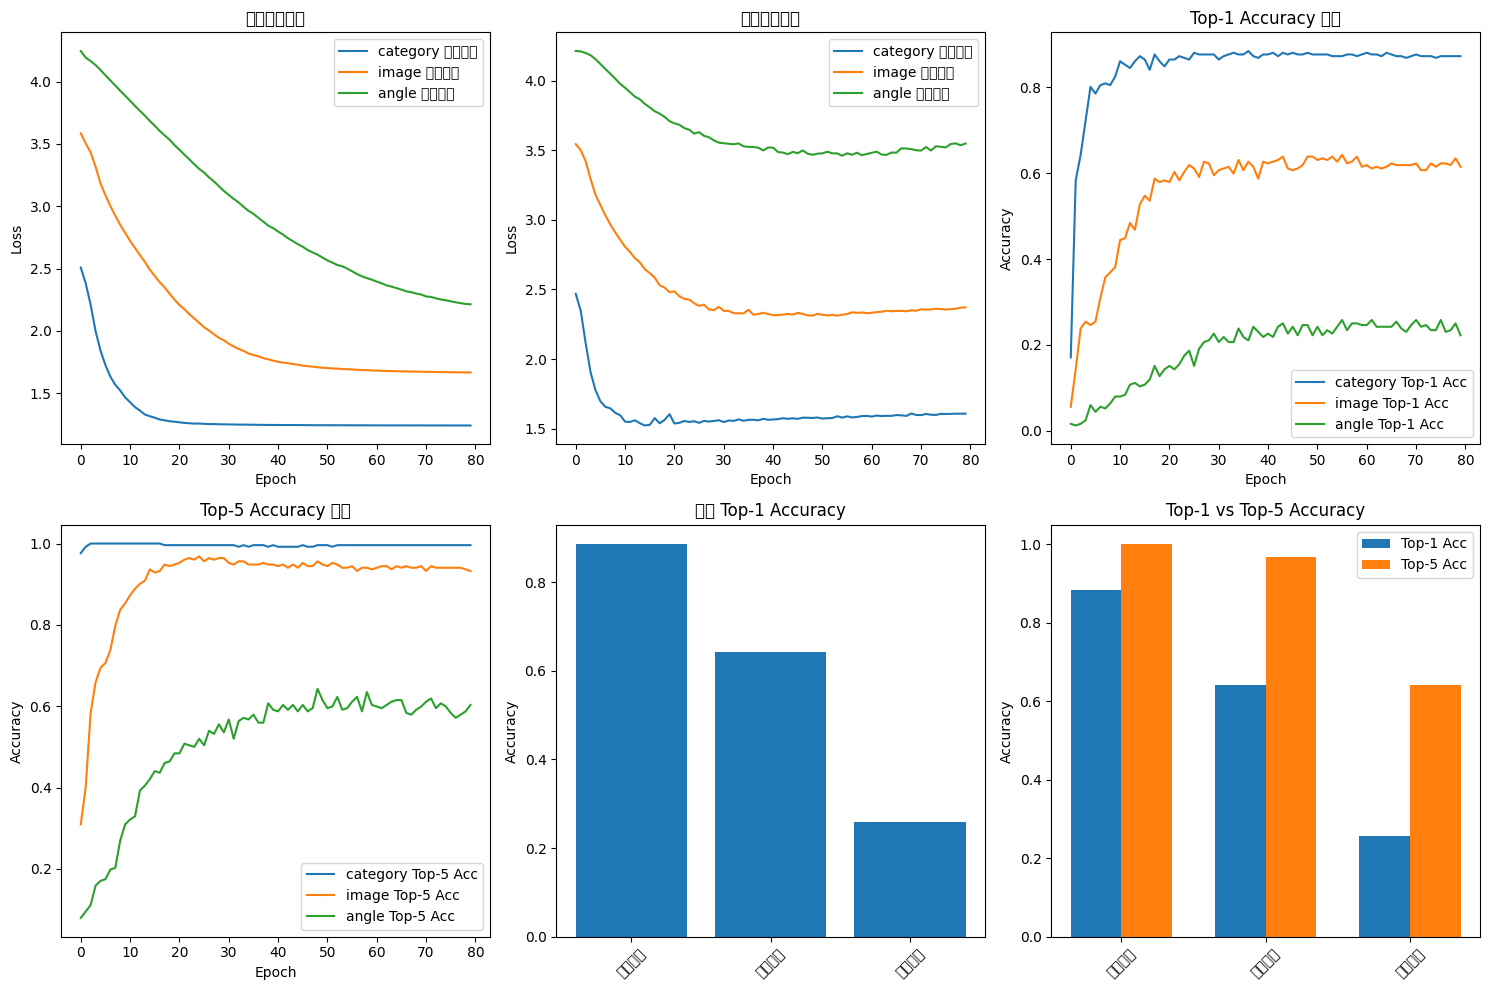


=== 训练结果总结 ===
大类分类:
  最佳 Top-1 Acc: 0.8849
  最佳 Top-5 Acc: 1.0000
  最佳 Epoch: 36

图片分类:
  最佳 Top-1 Acc: 0.6429
  最佳 Top-5 Acc: 0.9683
  最佳 Epoch: 55

角度分类:
  最佳 Top-1 Acc: 0.2579
  最佳 Top-5 Acc: 0.6429
  最佳 Epoch: 55



In [ ]:
# 绘制训练结果对比
plt.figure(figsize=(15, 10))

# 1. 损失曲线对比
plt.subplot(2, 3, 1)
for task_type, result in results.items():
    plt.plot(result['train_history']['loss'], label=f'{task_type} 训练损失')
plt.title('训练损失对比')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 3, 2)
for task_type, result in results.items():
    plt.plot(result['val_history']['loss'], label=f'{task_type} 验证损失')
plt.title('验证损失对比')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 2. Top-1 Accuracy 对比
plt.subplot(2, 3, 3)
for task_type, result in results.items():
    plt.plot(result['val_history']['top1_acc'], label=f'{task_type} Top-1 Acc')
plt.title('Top-1 Accuracy 对比')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 3. Top-5 Accuracy 对比
plt.subplot(2, 3, 4)
for task_type, result in results.items():
    plt.plot(result['val_history']['top5_acc'], label=f'{task_type} Top-5 Acc')
plt.title('Top-5 Accuracy 对比')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 4. 最佳性能总结
plt.subplot(2, 3, 5)
task_names = ['大类分类', '图片分类', '角度分类']
best_top1_accs = [results['category']['best_top1_acc'], 
                  results['image']['best_top1_acc'], 
                  results['angle']['best_top1_acc']]
plt.bar(task_names, best_top1_accs)
plt.title('最佳 Top-1 Accuracy')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)

# 5. Top-5 vs Top-1 对比
plt.subplot(2, 3, 6)
best_top5_accs = [max(results['category']['val_history']['top5_acc']), 
                  max(results['image']['val_history']['top5_acc']), 
                  max(results['angle']['val_history']['top5_acc'])]
x = np.arange(len(task_names))
width = 0.35
plt.bar(x - width/2, best_top1_accs, width, label='Top-1 Acc')
plt.bar(x + width/2, best_top5_accs, width, label='Top-5 Acc')
plt.title('Top-1 vs Top-5 Accuracy')
plt.ylabel('Accuracy')
plt.xticks(x, task_names, rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

# 打印性能总结
print("\n=== 训练结果总结 ===")
for task_type, result in results.items():
    task_name = {'category': '大类分类', 'image': '图片分类', 'angle': '角度分类'}[task_type]
    print(f"{task_name}:")
    print(f"  最佳 Top-1 Acc: {result['best_top1_acc']:.4f}")
    print(f"  最佳 Top-5 Acc: {max(result['val_history']['top5_acc']):.4f}")
    print(f"  最佳 Epoch: {result['best_epoch']}")
    print()  
